In [1]:
import os
import time
import torch
import random
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from exp.exp_main import Exp_Main
from data_provider.data_factory import data_provider
from torch.utils.data import DataLoader
from utils.timefeatures import time_features
from utils.tools import EarlyStopping, adjust_learning_rate, visual
from layers.Embed import DataEmbedding, DataEmbedding_wo_pos
from layers.AutoCorrelation import AutoCorrelation, AutoCorrelationLayer
from layers.FourierCorrelation import FourierBlock, FourierCrossAttention
from layers.MultiWaveletCorrelation import MultiWaveletCross, MultiWaveletTransform
from layers.SelfAttention_Family import FullAttention, ProbAttention
from layers.Autoformer_EncDec import Encoder, Decoder, EncoderLayer, DecoderLayer, my_Layernorm, series_decomp, series_decomp_multi
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

%matplotlib inline





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# fix_seed = int(100*random.random())

fix_seed = 7999
print(fix_seed)
random.seed(7999)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
channel = 44
filename = f'GBPJPY=X_{channel +1}.csv'

class Configs:
    # Basic configuration
    is_training = 1  # status, default 1
    task_id = 'train'  # task id, default 'test'
    model = 'FEDformer'  # model name, options: [FEDformer, Autoformer, Informer, Transformer], default 'FEDformer'

    # Supplementary configuration for FEDformer model
    version = 'Fourier'  # options: [Fourier, Wavelets], default 'Fourier'
    mode_select = 'random'  # mode selection method, options: [random, low], default 'random'
    L = 3  # ignore level, default 3
    base = 'legendre'  # mwt base, default 'legendre'
    cross_activation = 'tanh'  # mwt cross attention activation function, options: [tanh, softmax], default 'tanh'

    # Data loader configuration
    data = 'custom'  # dataset type, default 'ETTh1' set 'custom' for own data
    root_path = ''  # root path of the data file, default './dataset/ETT/'
    data_path = f'tr_{filename}'  # data file, default 'ETTh1.csv'
    features = 'MS'  # forecasting task, options: [M, S, MS], default 'M'
    target = 'Close'  # target feature in S or MS task, default 'OT'
    freq = 't'  # frequency for time features encoding, options: [s, t, h, d, b, w, m], default 'h'
    detail_freq = 't'  # detailed frequency, default help='like freq, but use in predict'
    checkpoints = './checkpoints/'  # location of model checkpoints, default './checkpoints/'

    # Forecasting task configuration
    seq_len = 36  # input sequence length, default 96
    pred_len = 36  # prediction sequence length, default 96
    
    # Model definition
    c_out = 1  # output size, default 7
    e_layers = 1  # number of encoder layers, default 2
    d_layers = 1  # number of decoder layers, default 1
    n_heads = 8  # number of heads, default 8  'attention heads'
    
    moving_avg = [24]  # window size of moving average, default [24]
    distil = True  # whether to use distilling in encoder, default True
    dropout = 0.0005  # dropout, default 0.05 --
    embed = 'timeF'  # time features encoding, options: [timeF, fixed, learned], default 'timeF' if timeF no time encoding
    activation = 'gelu'  # activation, default 'gelu'
    output_attention = False  # whether to output attention in encoder, default False
    do_predict = False  # whether to predict unseen future data, default False
    # Optimization configuration
    num_workers = 2  # data loader number of workers, default 10s
    # itr = 3               # experiments times, default 3 this is not equal to no of epochs
    patience = 6            # early stopping patience, default 3
    learning_rate = 0.0001  # optimizer learning rate, default 0.0001
    # des = 'Exp'           # experiment description, default 'test'
    loss = 'mse'            # loss funnction, default 'mse'
    lradj = 'type3'         # adjust learning rate, default 'type1'
    use_amp = False        # use automatic mixed precision training, default False
    # GPU configuration
    use_gpu = True  # use GPU, default True
    gpu = 0  # GPU, default 0
    use_multi_gpu = False  # use multiple GPUs, default False
    devices = '0,1'  # device ids of multiple GPUs, default '0,1'

    factor = 8 # attention factor, default 1
    label_len = 36  # start token length, default 48
    batch_size = 32        # batch size of train input data, default 32 d_ff>d_model
    d_ff = 4096 # dimension of fcn, default 2048
    d_model = 1024  # dimension of model, default 512 i was getting nan if itrained my model on 51
    enc_in = channel  # encoder input size, default 7
    dec_in = channel  # decoder input size, default 7
    modes = 64  # modes to be selected randomly, default 64
    train_epochs = 17 # train epochs, default 10



settings = Configs()
Exp = Exp_Main



setting = '{}_{}_{}_modes{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}'.format(
    settings.task_id,
    settings.model,
    settings.mode_select,
    settings.modes,
    settings.data,
    settings.features,
    settings.seq_len,
    settings.label_len,
    settings.pred_len,
    settings.d_model,
    settings.n_heads,
    settings.e_layers,
    settings.d_layers,
    settings.d_ff,
    settings.factor,
    settings.embed,
    settings.distil,
    # settings.des,
    0)

exp = Exp(settings)  # set experiments
print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
model , errors = exp.train(setting)
print('training finished')


7999
Use GPU: cuda:0
fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Autocorrelation used !
enc_modes: 18, dec_modes: 27
>>>>>>>start training : train_FEDformer_random_modes64_custom_ftMS_sl36_ll36_pl36_dm1024_nh8_el1_dl1_df4096_fc8_ebtimeF_dtTrue_0>>>>>>>>>>>>>>>>>>>>>>>>>>
1869
[561, 373, 0]
[1869, 561, 373]
train 1237 timeenc: 1
1869
[561, 373, 0]
[1869, 561, 373]
val 117 timeenc: 1
1869
[561, 373, 0]
[1869, 561, 373]
test 302 timeenc: 1
Loss criterion:  MSELoss()
running the training now
Epoch: 1 cost time: 19.47898507118225sec/epoch
Epoch: 1, Steps: 38 | Train Loss: 0.1379236 Vali Loss: 0.0855814 Test Loss: 0.1442929
Validation loss decreased (inf --> 0.085581).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 18.909088850021362sec/epoch
Epoch: 2, Steps: 38 |

In [2]:
model_parameters = sum(p.numel() for p in model.parameters())
print('total number of parameter in this model is {}'.format(model_parameters))
model_size_bytes = model_parameters * 4  # Assuming float32 weights
model_size_kb = model_size_bytes / 1024  # Convert bytes to kilobytes
print("Model size in KB:", model_size_kb)
print("Model size in MB:", model_size_kb//1024)


total number of parameter in this model is 48805391
Model size in KB: 190646.05859375
Model size in MB: 186.0


In [3]:
from data_provider.data_loader import Dataset_Pred, Dataset_Custom


data_set2 = Dataset_Custom(settings.root_path,flag='train',size=[settings.seq_len, settings.label_len, settings.pred_len],
                        features= settings.features, data_path=f'tr_{filename}', target=settings.target, scale=True, 
                         timeenc=1, freq=settings.freq)
scalerr = data_set2.get_scaler()
data_set = Dataset_Pred(settings.root_path,flag='pred',size=[settings.seq_len, settings.label_len, settings.pred_len],
                        features= settings.features, data_path=f'val_{filename}', target=settings.target, scale=True, 
                         timeenc=1, freq=settings.freq, scaler = scalerr, external_scaler = True)


batch_x, batch_y, batch_x_mark, batch_y_mark = data_set.get_last()

input_x = batch_x
input_x = input_x[:,-1:]
batch_x = torch.tensor(batch_x)
batch_x = batch_x.unsqueeze(0)
batch_x = batch_x.float().to(device)
batch_y = torch.tensor(batch_y)
batch_y = batch_y.unsqueeze(0)
batch_y = batch_y.float().to(device)
batch_x_mark = torch.tensor(batch_x_mark)
batch_x_mark = batch_x_mark.unsqueeze(0)
batch_x_mark = batch_x_mark.float().to(device)
batch_y_mark = torch.tensor(batch_y_mark)
batch_y_mark = batch_y_mark.unsqueeze(0)
batch_y_mark = batch_y_mark.float().to(device)
dec_inp = torch.zeros_like(batch_y[:, -settings.pred_len:, :]).float()
dec_inp = torch.cat([batch_y[:, :settings.label_len, :], dec_inp], dim=1).float().to(device)

model.eval()
outputs = model.forward(batch_x, batch_x_mark, dec_inp, batch_y_mark)


batch_y = batch_y[:, -settings.pred_len:, -1:]
criterion = nn.MSELoss()

# Call the instance with your tensors
# Ensure both tensors are on the same device (either both on CPU or both on GPU) and have the same shape
loss = criterion(outputs.squeeze(0).squeeze(-1), batch_y.squeeze(0).squeeze(-1))
print(loss.item())

                 
outputs = outputs.reshape(-1, 1)
zero_channels = torch.zeros(36, 12)
outputs = outputs.detach().cpu()
outputs = torch.cat((zero_channels, outputs), dim=1)
outputs= outputs[:,-1:]




input_x = input_x.squeeze()
input_x = input_x.reshape(-1, 1)

1869
[561, 373, 0]
[1869, 561, 373]
1.528319001197815


In [4]:
import yfinance as yf
import pandas as pd

df_val = pd.read_csv(f'val_{filename}') 
df_te = pd.read_csv(f'te_{filename}')

y_true = df_te[['Close']].values
x_val = df_val[['Close']].values

# print(x_val)


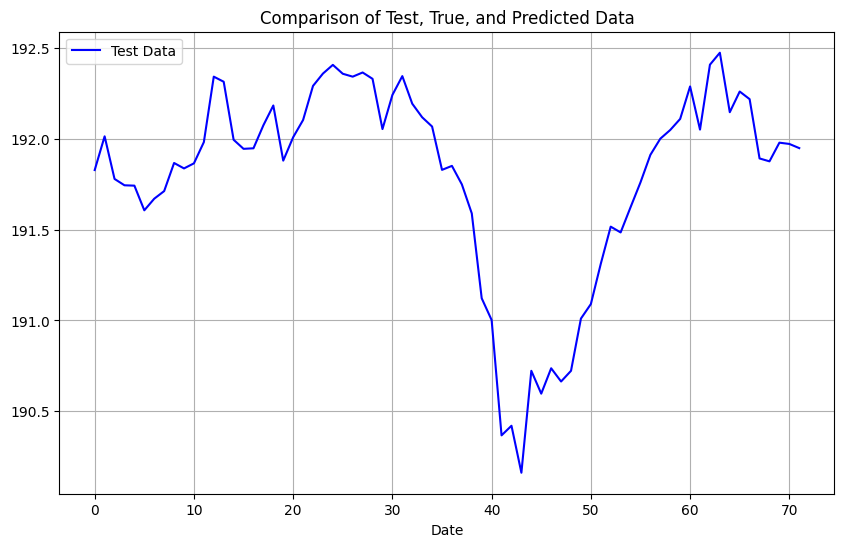

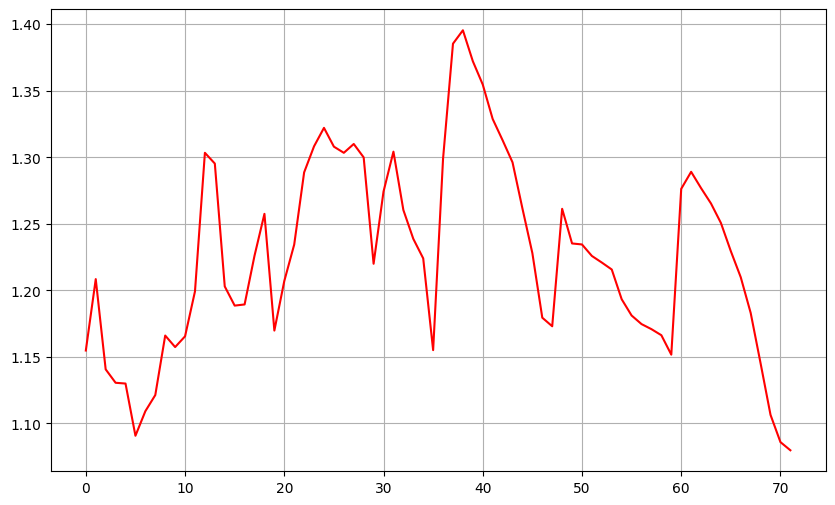

In [5]:
## import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
dates = pd.date_range('20230101', periods=36)  # Dummy date range
test_data = x_val.flatten()
true_data = y_true.flatten()
concatenated_array = np.concatenate((test_data, true_data))



predicted_data = np.concatenate((input_x, outputs))

# Plotting
plt.figure(figsize=(10, 6))
3
plt.plot( concatenated_array, label='Test Data', color='blue')
# plt.plot(test_data, label='True Data', color='green')

# Adding title and labels
plt.title('Comparison of Test, True, and Predicted Data')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
plt.figure(figsize=(10, 6))

# plt.plot(batch_y, label='Predicted Data', color='red')
# plt.plot(input_x, label='Predicted Data', color='red')
plt.grid(True)

plt.plot(predicted_data, label='Predicted Data', color='red')



1237


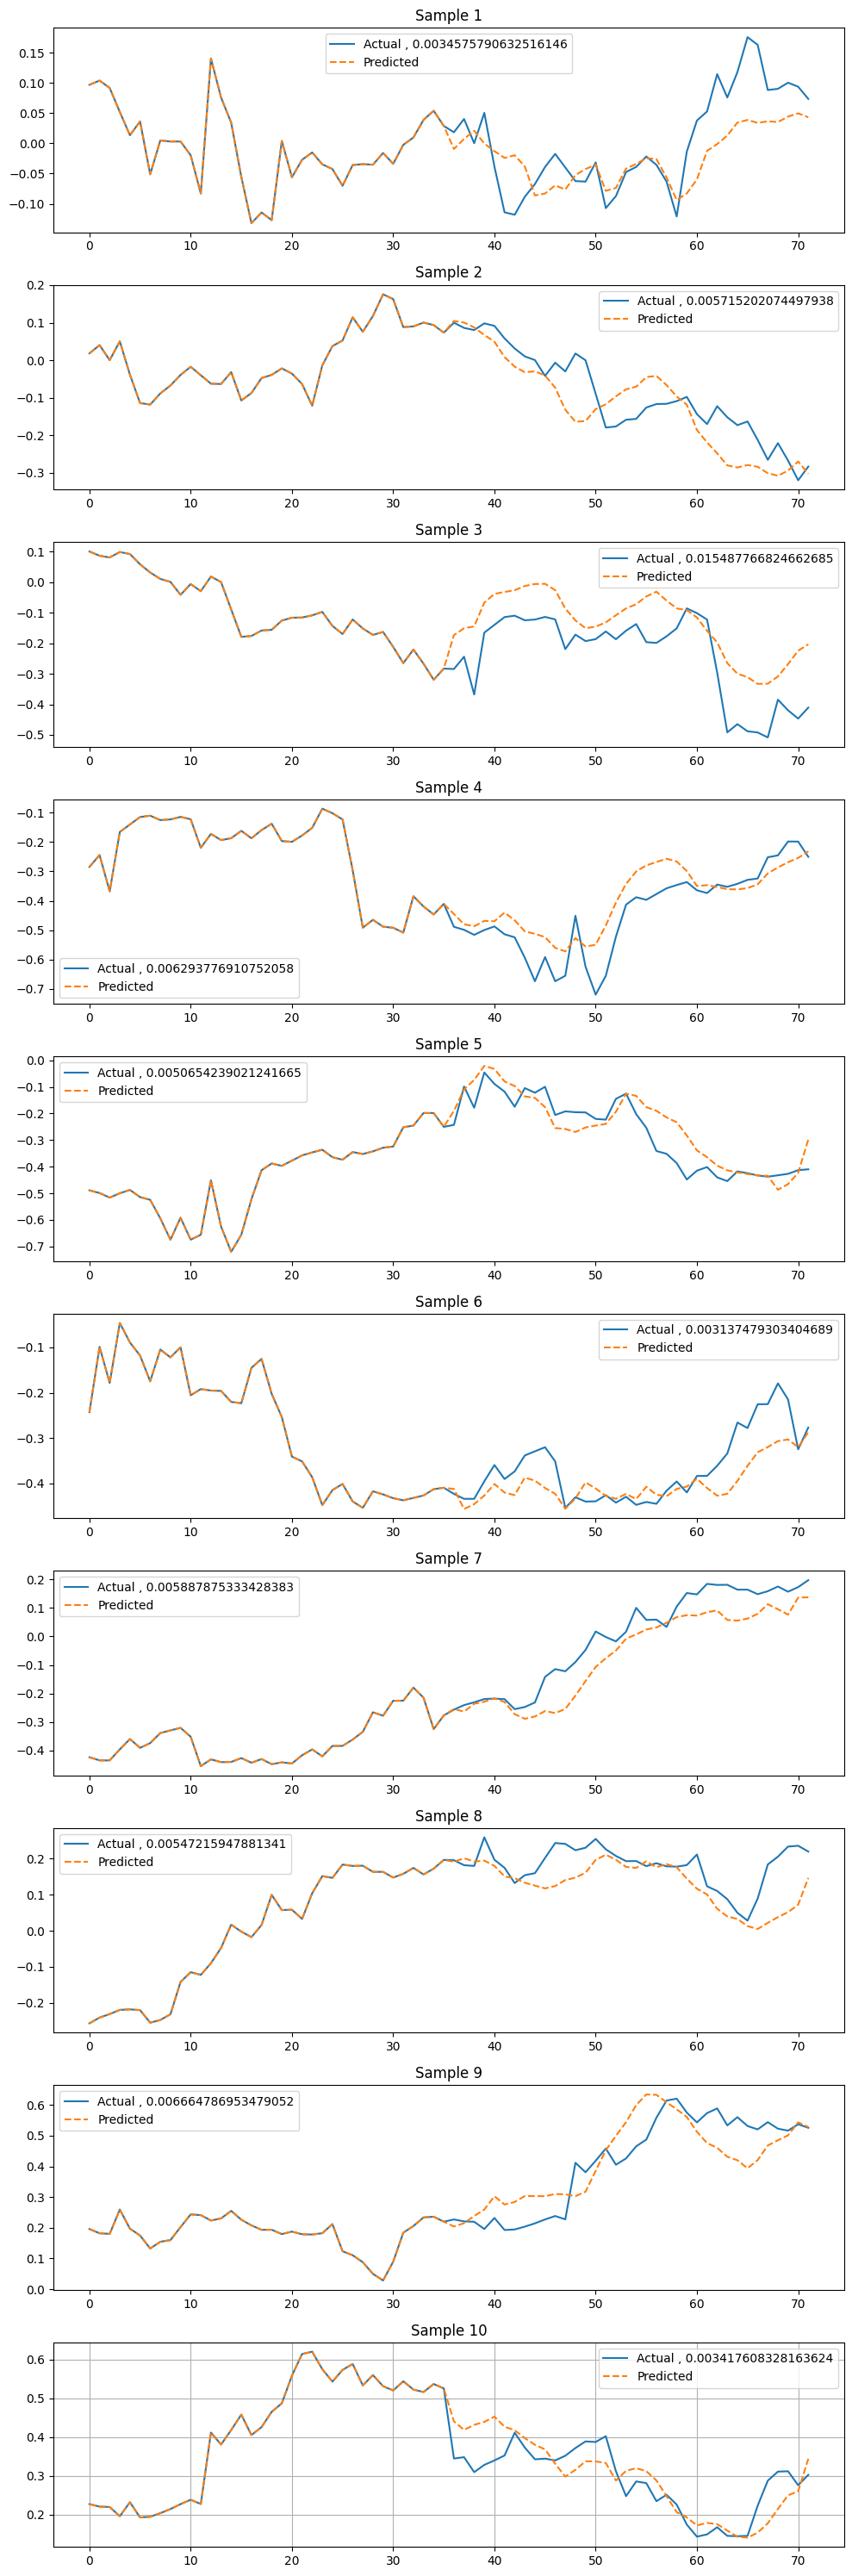

In [6]:
import torch
import matplotlib.pyplot as plt

# Assuming 'data_set' is already defined and loaded as in your script
# Define the number of samples you want to plot
n_samples = 10

# Assuming 'device' is already defined as in your script
model.eval()

# Set up the figure for plotting multiple subplots
fig, axs = plt.subplots(n_samples, 1, figsize=(10, n_samples * 3))  # Adjust the figure size as needed

lendata = data_set2.__len__()
print(lendata)
# Select and process n samples
for i in range(n_samples):
    batch_x, batch_y, batch_x_mark, batch_y_mark = data_set2.__getitem__(36*i)  # Adjusted to access samples directly if supported by your dataset class

    batch_x = torch.tensor(batch_x).unsqueeze(0).float().to(device)
    batch_y = torch.tensor(batch_y).unsqueeze(0).float().to(device)
    batch_x_mark = torch.tensor(batch_x_mark).unsqueeze(0).float().to(device)
    batch_y_mark = torch.tensor(batch_y_mark).unsqueeze(0).float().to(device)
    
    dec_inp = torch.zeros_like(batch_y[:, -settings.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :settings.label_len, :], dec_inp], dim=1).float().to(device)
    
    # Forward pass
    outputs = model.forward(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    batch_y = batch_y[:, -settings.pred_len:, -1:]
    pred = outputs.detach().cpu()
    true = batch_y.detach().cpu()

    loss = criterion(outputs.squeeze(0).squeeze(-1), batch_y.squeeze(0).squeeze(-1))

    
    # Reshaping and preparation for plotting
    outputs = outputs.squeeze(0).squeeze(-1).detach().cpu().numpy()
    actual = batch_y.squeeze(0).squeeze(-1).detach().cpu().numpy()

    inx = batch_x[:,:,-1:].squeeze(0).squeeze(-1).detach().cpu().numpy()
    d = np.concatenate((inx,actual))
    o = np.concatenate((inx,outputs))
    
    # Plotting the ith subplot
    axs[i].plot(d, label=f'Actual , {loss.item()}')
    axs[i].plot(o, label='Predicted', linestyle='--')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].legend()

# Adjust the layout so the titles and labels don't overlap

plt.tight_layout()
plt.grid(True)

plt.show()
